# A model bemutatása

### 1.) Beinportáljuk a megfelelő modulokat

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import zipfile

2023-10-18 14:23:39.363666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### 2.) Leszedjük a netről a kívánt adathalmazt zip állományként és kicsomagoljuk a program könyvtárába.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-10-18 01:03:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
A hitelesítésszolgáltatói tanúsítvány („/etc/ssl/certs/ca-certificates.crt”) betöltve
storage.googleapis.com (storage.googleapis.com) feloldása… 142.251.208.123, 142.250.180.251, 142.251.39.91, ...
Csatlakozás a következőhöz: storage.googleapis.com (storage.googleapis.com)[142.251.208.123]:443… kapcsolódva.
HTTP kérés elküldve, várakozás válaszra… 200 OK
Hossz: 519183241 (495M) [application/zip]
Mentés ide: „10_food_classes_all_data.zip.1”

10_food_classes_all 100%[===================>] 495,13M  11,2MB/s    idő 46s    

2023-10-18 01:04:19 (10,8 MB/s) -- „10_food_classes_all_data.zip.1” mentve [519183241/519183241]



### 3.) Betöltjük az adathalmazokat (azaz a megfelelő, kicsomagolt mappákat).

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    "10_food_classes_all_data/train/",
    image_size=(224, 224),
    batch_size=32,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "10_food_classes_all_data/test/",
    image_size=(224, 224),
    batch_size=32,
)

Found 7500 files belonging to 10 classes.


2023-10-18 14:23:47.730769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 14:23:47.866821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 14:23:47.867630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 2500 files belonging to 10 classes.


### 4.) Betöltünk egy újmond "fake" tanulóhalmazt is. Amit majd később összefésülünk az eredeti tanulóhalmazzal.

In [ ]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=40, # kép forgatása max 20 fokkal
        shear_range=0.3, # nyírás
        zoom_range=0.1, # nagyítás
        width_shift_range=0.2, # kép eltolása
        height_shift_range=0.2, # kép eltolása
        horizontal_flip=True # vízszintes tengely menti tükrözés
    )

augmented_train_ds = keras.preprocessing.image_dataset_from_directory(
    "10_food_classes_all_data/test/",
    image_size=(224, 224),
    batch_size=32,
)

Found 2500 files belonging to 10 classes.


### 5.) Előfeldolgozzuk az adatokat.

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)

### 6.) Beállítjuk a korai megállást:
#### Ha 3 korszakon keresztül nem csökken legalább 0.01-gyel az "éles" halmazon vizsgált veszteség, akkor leállítjuk a tanulási folyamatot.

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=3,
    restore_best_weights=True,
)

EPOCH = 25

### 7.) Létrehozzuk a model szerkezetét:
#### Alkalmazzuk a maxpooling technikáját (a képfájlméret kisebbítése végett), a kimeneti aktivációs függvényünk sigmoid, a többi mind ReLU.

In [ ]:
model = keras.Sequential(
    [
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(1024, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

### 8.) Lefordítjuk a modellünket az adam optimalizátort használva (adagrad-ot is próbáltam, de itt most nem jött be):

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### 9.) Kombináljuk az eredeti tesztadathalmazt a "fake" adatokkal.

In [ ]:
combined_train_ds = train_ds.concatenate(augmented_train_ds)

### 10.) Edzük a modelt, viszonylag nagy (256-os) köteg mérettel.
#### Az interneten kutakodva is ebbe fogunk belebotlani a legtöbbször.

In [ ]:
# Train the model
history = model.fit(
    combined_train_ds,
    epochs=EPOCH,
    validation_data=val_ds,
    callbacks=[early_stopping]
  )

# Evaluate the model
test_ds = keras.preprocessing.image_dataset_from_directory(
    "10_food_classes_all_data/test/",
    image_size=(224, 224),
    batch_size=256,
    shuffle=True
)

Epoch 1/25


/usr/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-10-18 14:24:10.185613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-18 14:24:16.231589: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-18 14:24:16.327939: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b46354ecf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-18 14:24:16.327965: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecuto

314/314 [==============================] - 184s 532ms/step - loss: 3.3165 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/25
314/314 [==============================] - 159s 505ms/step - loss: 2.3028 - accuracy: 0.0913 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/25
314/314 [==============================] - 159s 505ms/step - loss: 2.3028 - accuracy: 0.0929 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/25
314/314 [==============================] - 159s 506ms/step - loss: 2.3028 - accuracy: 0.0953 - val_loss: 2.3026 - val_accuracy: 0.1000
Found 2500 files belonging to 10 classes.


### 11.) Elmentjük a modelt és a fájljait egy mappába, majd képernyőre írjuk a model pontosságát.

In [ ]:
test_ds = test_ds.prefetch(buffer_size=32)
model.save("saved_trained_DL5_Homework_model")
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

# Print the accuracy
print("Test accuracy:", test_acc)

NameError: ignored

### 12.) Mindezek után grafikonokon szemléltetjük a tanuló -és "éles" halmaz veszteségfüggvényeit, pontosságait:

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCH)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

NameError: ignored

# Megkímélve mindenkit az újbóli futtatás borzalmaitól csatoltam pár előző futtatást.

Megjegyzés:
A 11. és 12. pont kódját lehet egy blokkba kellett volna rakni a 10-essel... :(

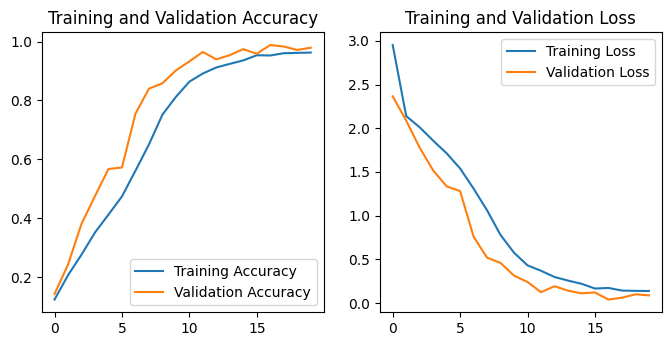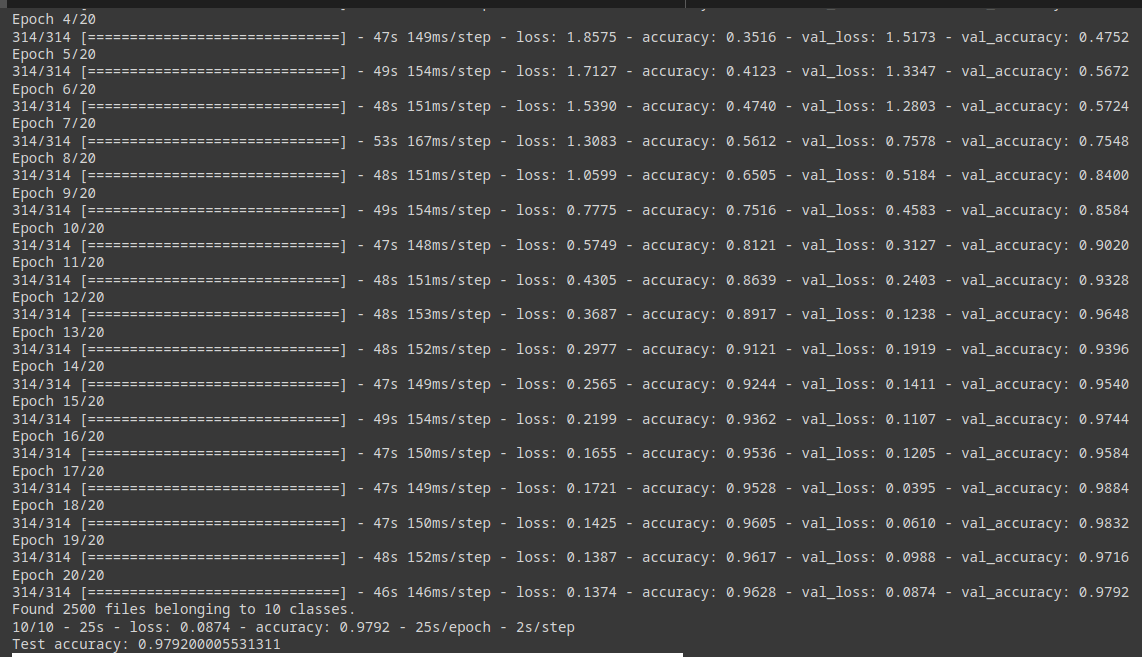